### Prediction of scraped MyAnimeList Data ###

Our goal in this project is to predict the popularity ranking of a supposed new show coming out using the basic information we would know about it before airing. <br>
We scraped our data from the side MyAnimeList (MAL for short). Link: https://myanimelist.net <br>
Example page from which we extracted data: (Attack on Titan) https://myanimelist.net/anime/16498

Importing 'numpy', 'pandas', 'matplotlib' and 'seaborn' for data management and visualization. 

In [2118]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

Prevent redundant warnings from pandas.

In [2119]:
import warnings
warnings.filterwarnings('ignore')

Reading the scraped data. The columns given regarding a show:
 - Title.
 - MAL Id. This method's input, its returned for convenience.
 - Type. For example: 'Movie', 'TV', ect.
 - Episode's duration. For example: '23 min', '2 hour', ect.
 - Publishing animation studio.
 - Source type. For example: 'Manga', 'Visual' (short for Visual Novel), ect.
 - Genres. For example: 'Fantasy', 'Romance', 'Action', etc.
 - Themes. For example: 'Military', 'Apocalypse', etc.
 - Rating. For example: 'PG-13'.
 - Popularity. Popularity ranking, lower is better.
 - Score. x out of 10, given by MAL user.
 - Year. Release year. For example: '2022'.
 - Number of Episodes. For example: '24'.
 - Demographic. Intended demographic. For example: 'shonen' (meaning young boys).

<b> Important Notes: </b> (TL;DR)
* Anime with lower Popularity means it was ranked lower, hence it means that the anime was viewed by more people.
* During our analysis and model training we won't be using the given Score of an anime to avoid data leakage as a popular anime is more likely to have a better score.

In [2120]:
df = pd.read_csv("anime_df_raw.csv", sep=';')
df.head(10)

,Unnamed: 0,Title,MAL Id,Type,Number of Episodes,Episode Duration,Studios,Source Type,Genres,Themes,Rating,Popularity,Score,Demographic,Year
0,0,Fullmetal Alchemist: Brotherhood,5114,TV,64,24 min. per ep.,Bones,Manga,"Action,Adventure,Comedy,Drama,Fantasy",N\A,R - 17+ (violence & profanity),3,9.15,Shounen,2009
1,1,Shingeki no Kyojin: The Final Season Part 2,48583,TV,12,23 min. per ep.,MAPPA,Manga,"Action,Drama,Fantasy,Mystery","Military,Super Power",R - 17+ (violence & profanity),220,9.15,Shounen,2022
2,2,Steins;Gate,9253,TV,24,24 min. per ep.,White Fox,Visual,"Drama,Sci-Fi,Suspense",N\A,PG-13 - Teens 13 or older,13,9.09,N\A,2011
3,3,Gintama°,28977,TV,51,24 min. per ep.,Bandai Namco Pictures,Manga,"Action,Comedy,Sci-Fi","Historical,Parody,Samurai",PG-13 - Teens 13 or older,335,9.09,Shounen,2015
4,4,Shingeki no Kyojin Season 3 Part 2,38524,TV,10,23 min. per ep.,Wit Studio,Manga,"Action,Drama,Fantasy,Mystery","Military,Super Power",R - 17+ (violence & profanity),32,9.08,Shounen,2019
5,5,Fruits Basket: The Final,42938,TV,13,23 min. per ep.,TMS Entertainment,Manga,"Drama,Romance,Slice of Life,Supernatural",N\A,PG-13 - Teens 13 or older,626,9.06,Shoujo,2021
6,6,Gintama',9969,TV,51,24 min. per ep.,Sunrise,Manga,"Action,Comedy,Sci-Fi","Historical,Parody,Samurai",PG-13 - Teens 13 or older,380,9.06,Shounen,2011
7,7,Gintama: The Final,39486,Movie,1,1 hr. 44 min.,Bandai Namco Pictures,Manga,"Action,Comedy,Drama,Sci-Fi","Historical,Parody,Samurai",PG-13 - Teens 13 or older,1798,9.05,Shounen,2021
8,8,Hunter x Hunter (2011),11061,TV,148,23 min. per ep.,Madhouse,Manga,"Action,Adventure,Fantasy",N\A,PG-13 - Teens 13 or older,10,9.05,Shounen,2011
9,9,Gintama': Enchousen,15417,TV,13,24 min. per ep.,Sunrise,Manga,"Action,Comedy,Sci-Fi","Historical,Parody,Samurai",PG-13 - Teens 13 or older,683,9.04,Shounen,2012


Delete null information. (if exists)

In [2121]:
data_null_total = pd.DataFrame(df.isna().sum()).T.rename({0:'total null'})
data_null_total

,Unnamed: 0,Title,MAL Id,Type,Number of Episodes,Episode Duration,Studios,Source Type,Genres,Themes,Rating,Popularity,Score,Demographic,Year
total null,0,0,0,0,0,0,0,0,0,0,0,0,0,0,204


Check for duplicated data entries.

In [2122]:
df = df.drop_duplicates(keep='first')

Lets remove entries with 'None' data:
 - 'add some' is a placeholder of shows without a known studio.
 - 'Unknown' source type.
 - All shows without listed genres.
 - All shows without a release year.

In [2123]:
#no_studio = df[df['Studios'].str.contains('add some')]
#df = pd.concat([df, no_studio])
#df = df.drop_duplicates(keep=False)

#print( 'Removed {} entries.'.format(len(no_studio.index)) )

In [2124]:
no_source = df[df['Source Type'].str.contains('Unknown')]
df = pd.concat([df, no_source])
df = df.drop_duplicates(keep=False)

print( 'Removed {} entries.'.format(len(no_source.index)) )

Removed 1289 entries.


In [2125]:
no_genre = df[df['Genres'] == 'N\A']
df = pd.concat([df, no_genre])
df = df.drop_duplicates(keep=False)

print( 'Removed {} entries.'.format(len(no_genre.index)) )

Removed 1877 entries.


In [2126]:
no_ep_num = df[df['Number of Episodes'] == 'Unknown']
df = pd.concat([df, no_ep_num])
df = df.drop_duplicates(keep=False)

print( 'Removed {} entries.'.format(len(no_ep_num.index)) )

Removed 28 entries.


In [2127]:
clean_df = df[pd.to_numeric(df['Year'], errors='coerce').notnull()]

print( 'Removed {} entries.'.format(len(df.index) - len(clean_df.index)) )
df = clean_df

Removed 69 entries.


In [2128]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6234 entries, 0 to 9493
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Unnamed: 0          6234 non-null   int64  
 1   Title               6234 non-null   object 
 2   MAL Id              6234 non-null   int64  
 3   Type                6234 non-null   object 
 4   Number of Episodes  6234 non-null   object 
 5   Episode Duration    6234 non-null   object 
 6   Studios             6234 non-null   object 
 7   Source Type         6234 non-null   object 
 8   Genres              6234 non-null   object 
 9   Themes              6234 non-null   object 
 10  Rating              6234 non-null   object 
 11  Popularity          6234 non-null   int64  
 12  Score               6234 non-null   float64
 13  Demographic         6234 non-null   object 
 14  Year                6234 non-null   object 
dtypes: float64(1), int64(3), object(11)
memory usage: 779.2

Lets parse the data that is still saved as a string so we can work with it.

Lets convert the Release year to 'int'.

In [2129]:
df['Year'] = df['Year'].astype(int)

lets convert 'Number of Episodes' to an 'int.

In [2130]:
df['Number of Episodes'] = df['Number of Episodes'].astype(int)

Parsing Episode Duration to 'int' minutes.

In [2131]:
def DurationToMin(duration_str):
    duration_list = duration_str.split(' ')
    duration = 0

    i = 0
    for word in duration_list:
        if word == 'min.':
            duration += int(duration_list[i-1])
        elif word == 'hr.':
            duration += 60*int(duration_list[i-1])
        i += 1

    return duration

In [2132]:
df['Duration'] = df['Episode Duration'].apply(lambda x: DurationToMin(x))

In [2133]:
df = df.drop(['Unnamed: 0'], axis=1)

Lets remove shows with episode duration smaller than 1 minute.

In [2134]:
no_duration = df[df['Duration'] == 0]
df = pd.concat([df, no_duration])
df = df.drop_duplicates(keep=False)

print( 'Removed {} entries.'.format(len(no_duration.index)) )

Removed 21 entries.


In [2135]:
df

,Title,MAL Id,Type,Number of Episodes,Episode Duration,Studios,Source Type,Genres,Themes,Rating,Popularity,Score,Demographic,Year,Duration
0,Fullmetal Alchemist: Brotherhood,5114,TV,64,24 min. per ep.,Bones,Manga,"Action,Adventure,Comedy,Drama,Fantasy",N\A,R - 17+ (violence & profanity),3,9.15,Shounen,2009,24
1,Shingeki no Kyojin: The Final Season Part 2,48583,TV,12,23 min. per ep.,MAPPA,Manga,"Action,Drama,Fantasy,Mystery","Military,Super Power",R - 17+ (violence & profanity),220,9.15,Shounen,2022,23
2,Steins;Gate,9253,TV,24,24 min. per ep.,White Fox,Visual,"Drama,Sci-Fi,Suspense",N\A,PG-13 - Teens 13 or older,13,9.09,N\A,2011,24
3,Gintama°,28977,TV,51,24 min. per ep.,Bandai Namco Pictures,Manga,"Action,Comedy,Sci-Fi","Historical,Parody,Samurai",PG-13 - Teens 13 or older,335,9.09,Shounen,2015,24
4,Shingeki no Kyojin Season 3 Part 2,38524,TV,10,23 min. per ep.,Wit Studio,Manga,"Action,Drama,Fantasy,Mystery","Military,Super Power",R - 17+ (violence & profanity),32,9.08,Shounen,2019,23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9484,Ugokie Kori no Tatehiki,3929,Movie,1,11 min.,add some,Original,"Comedy,Supernatural",N\A,G - All Ages,10841,5.66,N\A,1933,11
9487,California Crisis: Tsuigeki no Juuka,3127,OVA,1,45 min.,"Studio Unicorn,Hiro Media",Original,"Action,Adventure,Sci-Fi",N\A,PG-13 - Teens 13 or older,7041,5.66,N\A,1986,45
9491,Hipira-kun ONA,22983,ONA,2,5 min. per ep.,Sunrise,Picture,"Comedy,Fantasy,Supernatural",N\A,PG - Children,11824,5.66,Kids,2010,5
9492,Install Pilot,11043,Special,1,12 min.,Asahi Production,Original,"Action,Sci-Fi",N\A,R - 17+ (violence & profanity),12229,5.66,Shounen,2011,12


The models cannot accept string values hence we will create boolean values for each genre related to a show. We will convert the True/False value into 1/0 (respectively) for it to be numerical data.

In [2136]:
def GetAttributeList(column, dataframe, none_value):
    attribute_list = []
    for cell in dataframe[column]:
        attributes = cell.split(',')
        for attribute in attributes:
            if attribute not in attribute_list and none_value not in attribute:
                attribute_list.append(attribute)

    return attribute_list

def AttributeListToBoolFlags(column, dataframe, none_value):
    attribute_list = GetAttributeList(column, dataframe, none_value)

    print( 'There are {} {}.\n {}'.format(len(attribute_list), column, attribute_list) )

    for attribute in attribute_list:
        dataframe[attribute] = dataframe.apply (lambda row: 1 if attribute in row[column] else 0, axis=1)

In [2137]:
AttributeListToBoolFlags('Genres', df, 'N\A')
AttributeListToBoolFlags('Themes', df, 'N\A')
AttributeListToBoolFlags('Source Type', df, 'Other')

There are 20 Genres.
 ['Action', 'Adventure', 'Comedy', 'Drama', 'Fantasy', 'Mystery', 'Sci-Fi', 'Suspense', 'Romance', 'Slice of Life', 'Supernatural', 'Sports', 'Award Winning', 'Ecchi', 'Horror', 'Avant Garde', 'Boys Love', 'Gourmet', 'Girls Love', 'Work Life']
There are 17 Themes.
 ['Military', 'Super Power', 'Historical', 'Parody', 'Samurai', 'Space', 'Mecha', 'Demons', 'Martial Arts', 'School', 'Music', 'Psychological', 'Police', 'Game', 'Harem', 'Vampire', 'Cars']
There are 15 Source Type.
 ['Manga', 'Visual', 'Novel', 'Light', 'Original', 'Web', '4-koma', 'Book', 'Game', 'Picture', 'Card', 'Music', 'Mixed', 'Digital', 'Radio']


lets remove the genres that we barely see (< 5 times), if left alone they would serve as edge cases for our predictions.

In [2138]:
genre_list = GetAttributeList('Genres', df, 'N\A')

for genre in genre_list:
    count = df[genre].value_counts()[1]
    if count < 5:
        df = df.drop(genre, axis=1)

genre_list = GetAttributeList('Themes', df, 'N\A')

for genre in genre_list:
    count = df[genre].value_counts()[1]
    if count < 5:
        df = df.drop(genre, axis=1)

genre_list = GetAttributeList('Source Type', df, 'Other')

for genre in genre_list:
    count = df[genre].value_counts()[1]
    if count < 10:
        df = df.drop(genre, axis=1)

The models cannot accept string values hence we will create boolean values for the rating, type and demographic related to each show just as we did for genre.

In [2139]:
AttributeListToBoolFlags('Rating', df, 'None')
AttributeListToBoolFlags('Type', df, 'N\A')
AttributeListToBoolFlags('Demographic', df, 'N\A')

There are 5 Rating.
 [' R - 17+ (violence & profanity)  ', ' PG-13 - Teens 13 or older  ', ' R+ - Mild Nudity  ', ' PG - Children  ', ' G - All Ages  ']
There are 5 Type.
 ['TV', 'Movie', 'OVA', 'ONA', 'Special']
There are 5 Demographic.
 ['Shounen', 'Shoujo', 'Seinen', 'Josei', 'Kids']


After removing a large quantity of entries the 'Popularity' column, which represents the show's popularity <b> rank </b>, would have gaps in its values, leading to an unbalanced data set. We will bridge those rankings while keeping their original order to avoid the issue.

In [2140]:
df.sort_values('Popularity')


for index, value in df.iterrows():
    df.loc[index, 'Popularity'] = index

Now the 'index' column and the 'popularity' column are identical. To avoid data leakage we will remove the index column and reset them after shuffling the dataframe.

In [2141]:
#df = df.drop(['index'], axis=1)
df['Popularity']

0          0
1          1
2          2
3          3
4          4
        ... 
9484    9484
9487    9487
9491    9491
9492    9492
9493    9493
Name: Popularity, Length: 6213, dtype: int64

Lets shuffle the data.

In [2142]:
df = df.sample(frac=1).reset_index(drop=True)

In [2143]:
df.to_csv("anime_df_clean.csv", sep=';', index=False)
df

,Title,MAL Id,Type,Number of Episodes,Episode Duration,Studios,Source Type,Genres,Themes,Rating,...,TV,Movie,OVA,ONA,Special,Shounen,Shoujo,Seinen,Josei,Kids
0,Bem,39221,TV,12,24 min. per ep.,"Production I.G,LandQ studios",Original,"Action,Supernatural",N\A,PG-13 - Teens 13 or older,...,1,0,0,0,0,0,0,0,0,0
1,Monster Strike: Zoku Saishuu-banashi - Pandora...,34661,ONA,1,8 min.,add some,Game,"Action,Fantasy",N\A,PG-13 - Teens 13 or older,...,0,0,0,1,0,0,0,0,0,0
2,Amagi Brilliant Park: Nonbirishiteiru Hima ga ...,30206,Special,1,23 min.,Kyoto Animation,Light,"Comedy,Fantasy",N\A,PG-13 - Teens 13 or older,...,0,0,0,0,1,0,0,0,0,0
3,Wellber no Monogatari: Sisters of Wellber,2032,TV,13,24 min. per ep.,Trans Arts,Original,"Action,Adventure,Comedy,Drama,Fantasy",N\A,PG-13 - Teens 13 or older,...,1,0,0,0,0,0,0,0,0,0
4,Gintama.: Porori-hen,35843,TV,13,23 min. per ep.,Bandai Namco Pictures,Manga,"Action,Comedy,Sci-Fi","Historical,Parody,Samurai",PG-13 - Teens 13 or older,...,1,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6208,Hitori no Shita: The Outcast 2nd Season,35333,ONA,24,24 min. per ep.,Haoliners Animation League,Web,"Action,Supernatural",N\A,R - 17+ (violence & profanity),...,0,0,0,1,0,0,0,0,0,0
6209,Nameko-ke no Ichizoku,20539,OVA,13,5 min. per ep.,add some,Game,"Comedy,Slice of Life",N\A,G - All Ages,...,0,0,1,0,0,0,0,0,0,0
6210,Persona 3 the Movie 4: Winter of Rebirth,31149,Movie,1,1 hr. 45 min.,A-1 Pictures,Game,"Action,Fantasy,Supernatural",N\A,R - 17+ (violence & profanity),...,0,1,0,0,0,0,0,0,0,0
6211,Inugami-san to Nekoyama-san,22123,TV,12,3 min. per ep.,Seven,4-koma,"Comedy,Girls Love",N\A,PG-13 - Teens 13 or older,...,1,0,0,0,0,0,0,0,0,0


Now that we cleaned the data we will try to gain some insight into the correlation between parameters and confirm our own suspicions.

### Correlation ###

In [2144]:
def CorrelationTable(data, title):
    # Compute the correlation matrix:
    pandas_correlation = data.corr()

    # Generating a mask for the upper triangle for a cleaner table:
    mask = np.triu(np.ones_like(pandas_correlation, dtype=bool))

    # Set up the matplotlib figure:
    f, ax = plt.subplots(figsize=(50, 50))

    # Generate a custom diverging colormap:
    cmap = sns.diverging_palette(20, 230, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio:
    sns.heatmap(pandas_correlation, mask=mask, cmap=cmap, vmax=.8, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

    # Title:
    plt.title(title)

    plt.show()

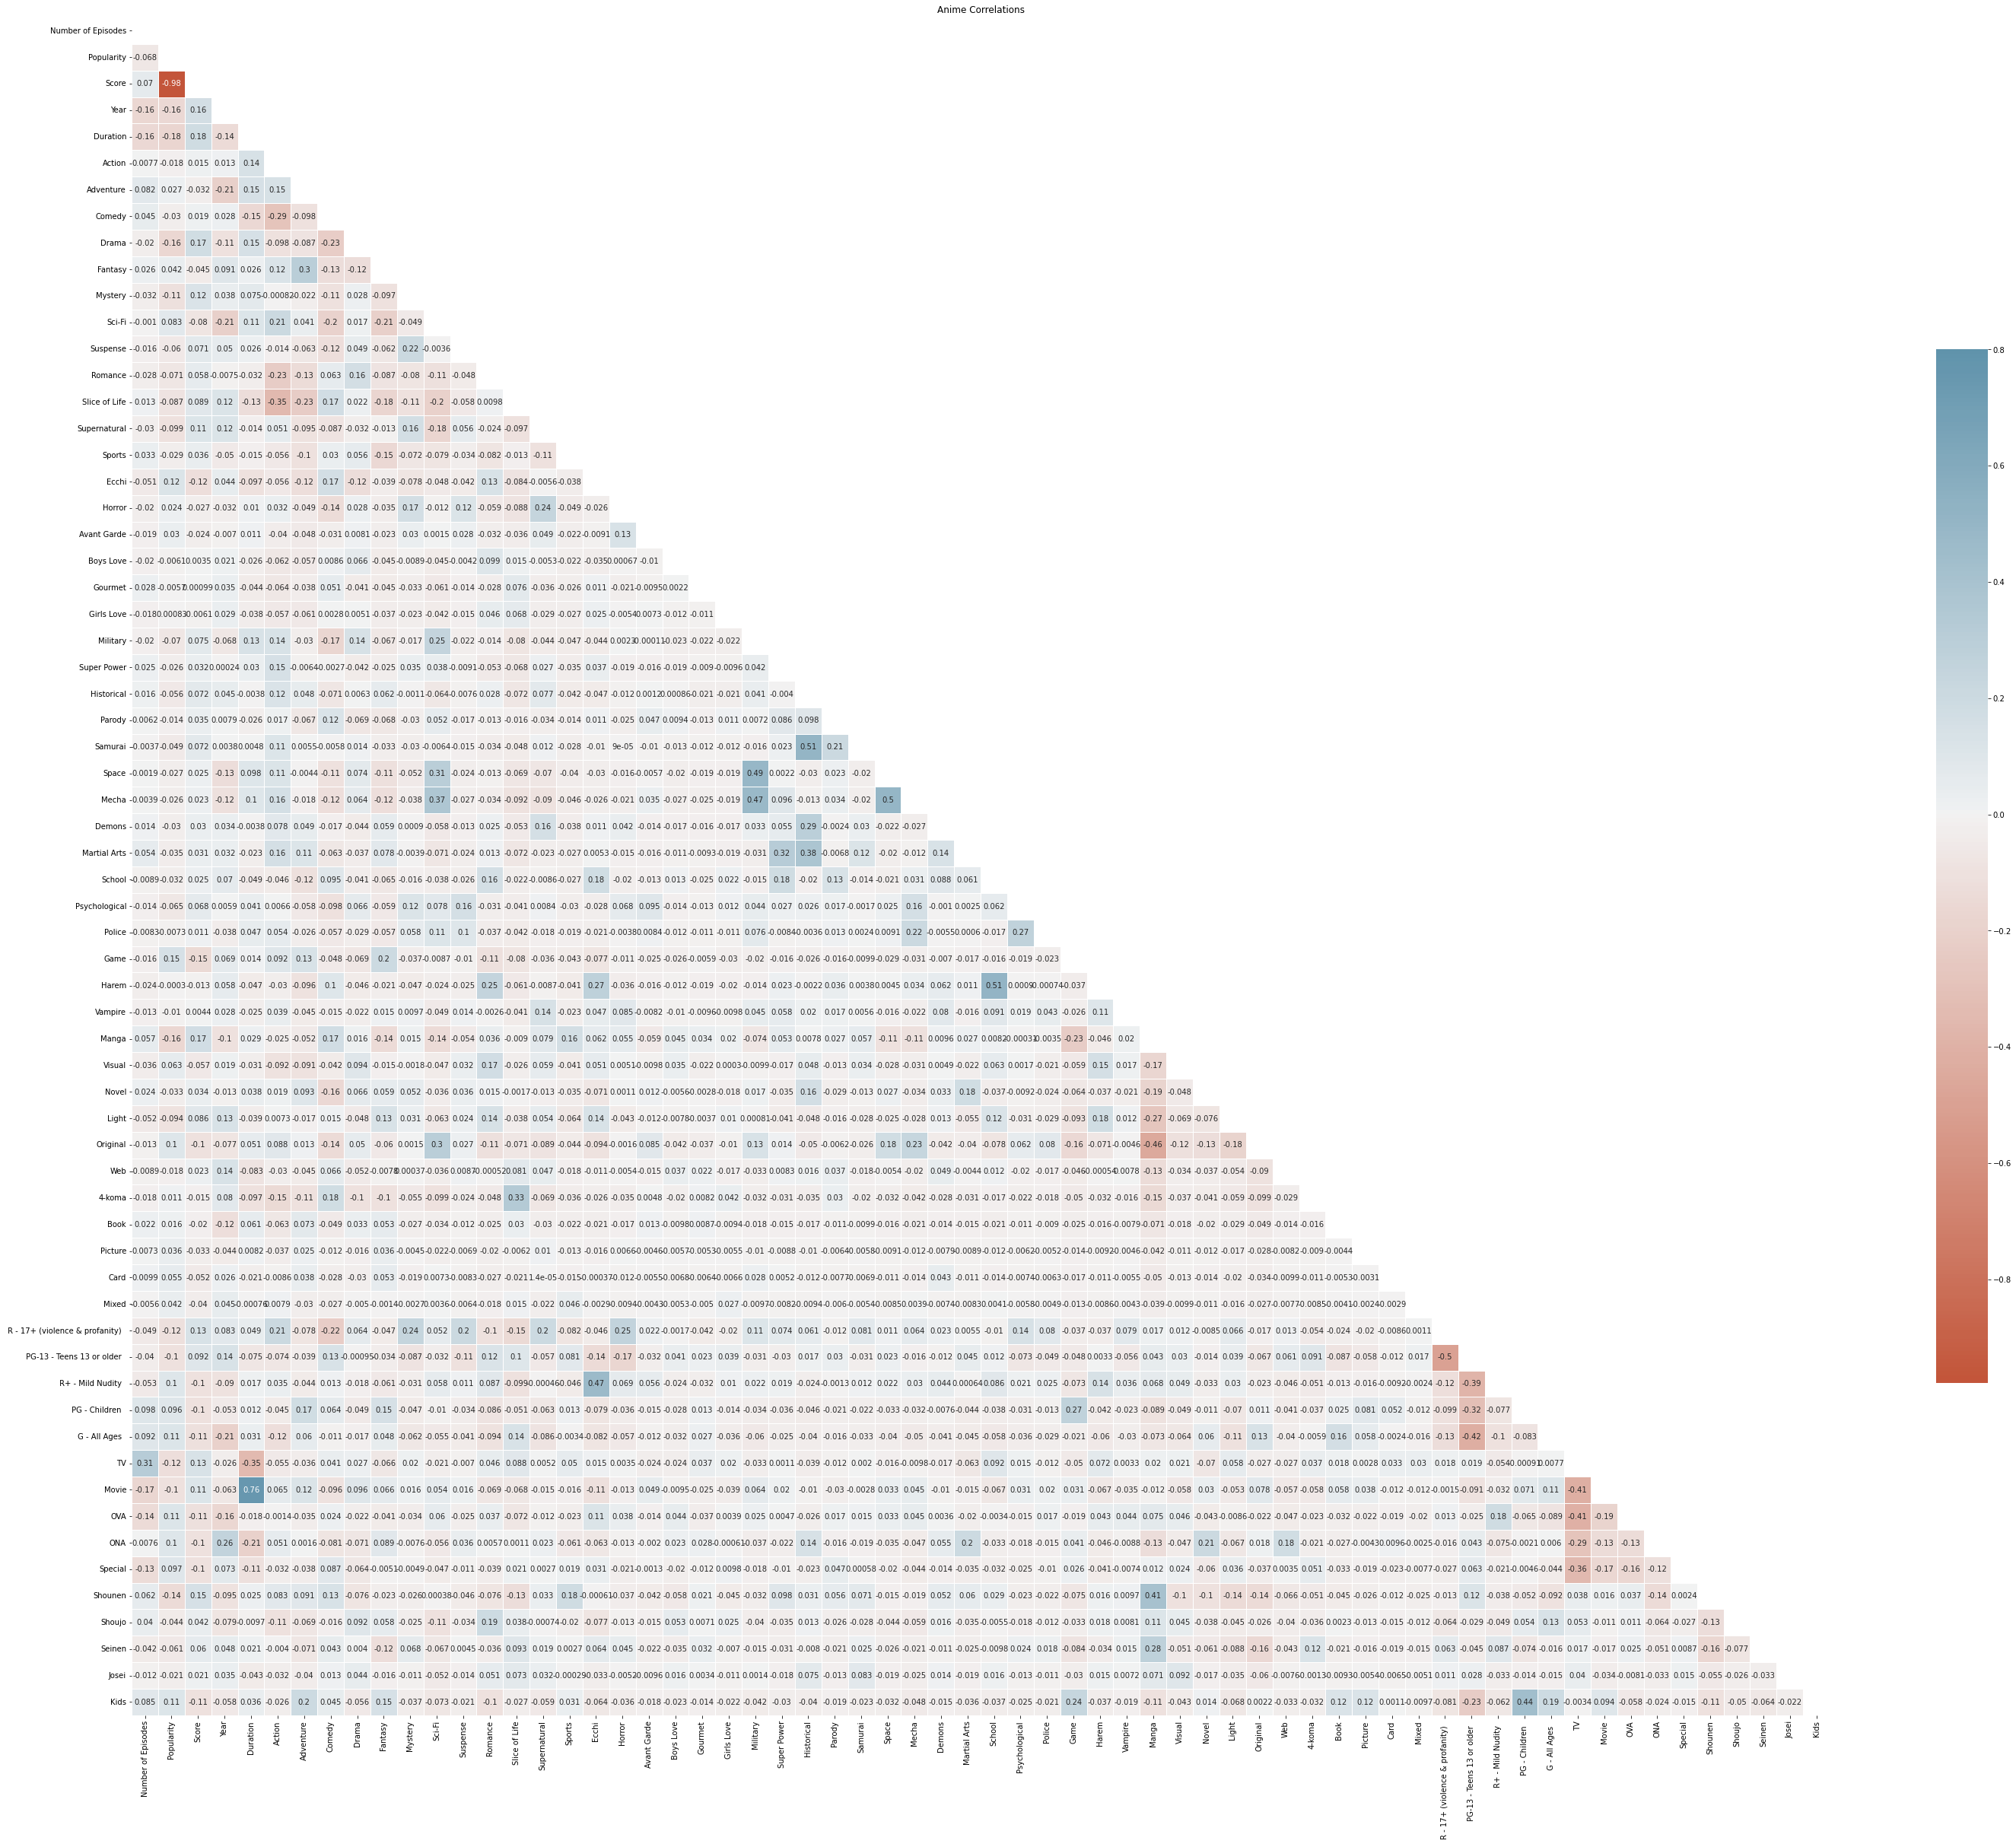

In [2145]:
corr_df = df.drop(['Title', 'Episode Duration', 'Genres', 'Themes', 'Studios', 'Source Type', 'Type', 'Rating', 'Demographic', 'MAL Id'], axis=1)
CorrelationTable(corr_df, 'Anime Correlations')

<b> Reminder! </b> <br>
Anime with lower Popularity means it was ranked lower, hence it means that the anime was viewed by more people.
In addition, we looked at Score even though we will not use it because of its strong connection to Popularity in order to gain further insight.

<b> Important connections: </b> (Relatively strong relations to popularity)
* Year, Popularity : (-0.35) There is a strong connection between year and popularity, that shows new anime tend to be more popular (ranked lower).
* Romance, Popularity: (-0.14) Anime with romance genre tend to get a lower rank.
* Supernatural, Popularity: (-0.16) Anime with Supernatural genre tend to get a lower rank.
* Ecchi, Popularity: (-0.12) Anime with Ecchi genre tend to get a lower rank.
* R - 17+ (violence & profanity), Popularity: (-0.19) Anime with this rating tends to be lower ranked.
* G - All Ages, Popularity: (0.29) There is a strong connection that indicates anime for all ages will be higher ranked.
* TV, Popularity: (-0.3) There is a strong connection between anime's rank and the fact it was aired on TV.
* ONA, Popularity: (0.22) There is a relatively strong connection between anime's rank and the fact it was aired on a website.
* Shounen, Popularity: (-0.097) Anime with Shounen demography tend to get lower ranked.
* Kids, Popularity: (0.13) Anime for kids tend to be higher ranked.

<b> Relatively strong connections to score: </b>
* Duration , Score: (0.18) Anime with higher duration per episode tend to get a better score.
* Drama, Score: (0.17) Anime with Drama genre tend to get higher score.
* Supernatural, Score: (0.11): Anime with supernatural genre tend to get higher score.
* R - 17+ (violence & profanity), Score: (0.13) Anime with this rating tends to get higher score.
* TV, Score: (0.1) Anime that was aired on TV tend to get higher score.
* Shounen, Score : (0.14) Anime with Shounen demography tend to get higher score.
* Kids, Score: (-0.1) Anime for kids tend to get lower score.
* Score, Number of Episodes: (0.073) Anime with more episodes tend to get a greater score.
* Year, Score: (0.16) New anime tend to receive a greater score.

<b> Examples for expectations using the connections: </b> <br>

We expect that an anime with the following data will be relatively lower ranked (With lower Popularity):
* The anime was released in the last few years
* The anime's genres are: Romance, Supernatural , Ecchi 
* The anime is rated 17+ (violence & profanity)
* The anime was aired on TV
* The anime's demography is Shounen

We expect that an anime with the following data will be relatively higher ranked (With higher popularity):
* The anime was released a relatively long time ago
* The anime's genres are: Adventure, Sci-Fi
* The anime is rated for all ages
* The anime was aired on a website 
* The anime demography is kids

### Graphs ###

We use this graph to see how many times each genre appear in order to get a better understanding of our data.
For example, which genre is the most used.

We expect that if a genre appears a low number of times, it means that anime with that genre will have a relatively higher Popularity value, meaning worse.

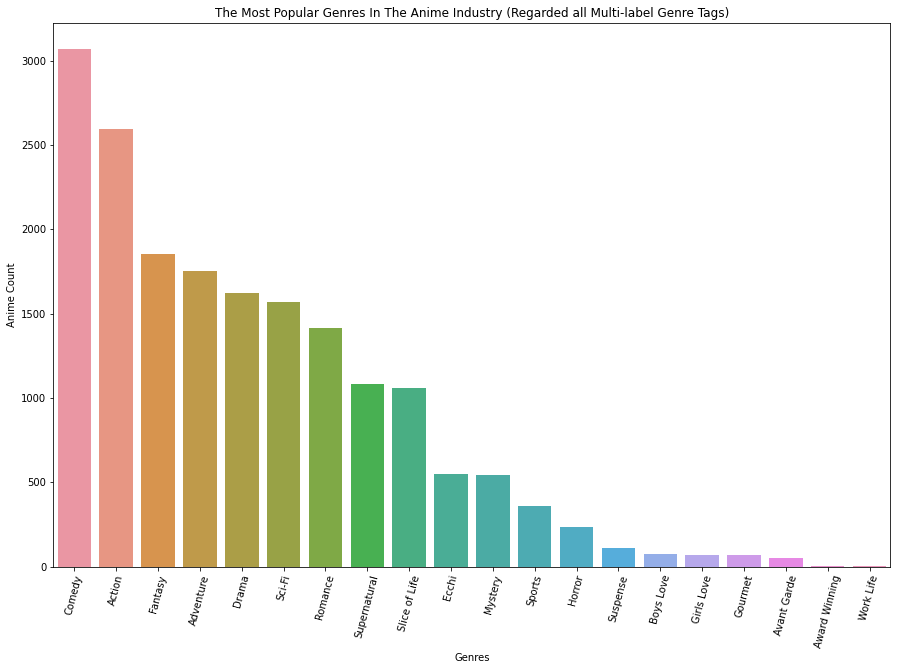

In [2146]:
#cut genres
#median genre popularity
#make chart of genre vs populrity
genre_list = []

genre_splited = []

for i in df['Genres']:
    for j in i.split(","):
        genre_splited.append(j)
        if j not in genre_list:
            genre_list.append(j)   
        
anime_genres_count = pd.Series(genre_splited).value_counts() 

plt.figure(figsize=(15,10))
sns.barplot(x=anime_genres_count.index.tolist(), y=anime_genres_count.tolist())
plt.xlabel('Genres')
plt.ylabel('Anime Count')
plt.title('The Most Popular Genres In The Anime Industry (Regarded all Multi-label Genre Tags)') 
plt.xticks(rotation= 75) 
plt.show()     



We use this Graph to check how balance our data is: Since we remove some of our data, we had to verify that we have samples of low and high popularity anime.

<AxesSubplot:title={'center':'How many times each popularity appears modul 500'}, xlabel='Popularity'>

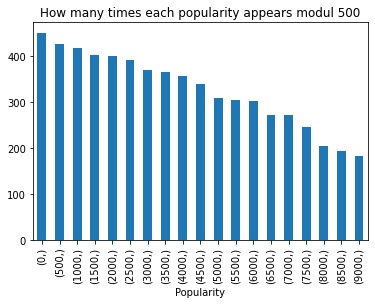

In [2147]:
plt.title('How many times each popularity appears modul 500')
df_popularity = df[['Popularity']].apply(lambda x: (x-(x%500)))
df_popularity

df_popularity_count = df_popularity.value_counts()
df_popularity_count.plot(kind = 'bar')

We use this graph to see how many times each source appear in order to get a better understanding of our data.
For example, which source is the most common.

We expect that if a source appears a low number of times, it means that anime with that source will have a relatively higher Popularity value, meaning worse.

<AxesSubplot:title={'center':'Source and the Number of Published Anime'}>

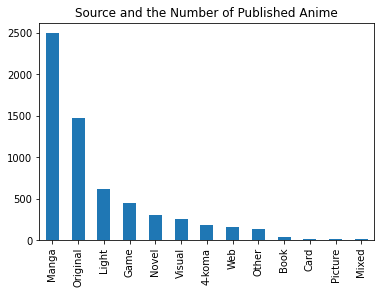

In [2148]:
plt.title('Source and the Number of Published Anime')
source_appearances = df['Source Type'].value_counts()
source_appearances[source_appearances>10].plot(kind = 'bar')

<AxesSubplot:title={'center':'Source and the Number of Published Anime'}>

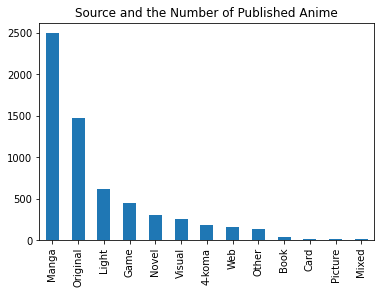

In [2149]:
plt.title('Source and the Number of Published Anime')
source_appearances = df['Source Type'].value_counts()
source_appearances[source_appearances>10].plot(kind = 'bar')

In [2150]:
df_lowpop = df[df['Popularity']<100]
df_lowpop

,Title,MAL Id,Type,Number of Episodes,Episode Duration,Studios,Source Type,Genres,Themes,Rating,...,TV,Movie,OVA,ONA,Special,Shounen,Shoujo,Seinen,Josei,Kids
4,Gintama.: Porori-hen,35843,TV,13,23 min. per ep.,Bandai Namco Pictures,Manga,"Action,Comedy,Sci-Fi","Historical,Parody,Samurai",PG-13 - Teens 13 or older,...,1,0,0,0,0,1,0,0,0,0
166,Natsume Yuujinchou Shi,11665,TV,13,24 min. per ep.,Brain's Base,Manga,"Drama,Slice of Life,Supernatural",N\A,PG-13 - Teens 13 or older,...,1,0,0,0,0,0,1,0,0,0
239,Gintama Movie 1: Shinyaku Benizakura-hen,7472,Movie,1,1 hr. 35 min.,Sunrise,Manga,"Action,Comedy,Sci-Fi","Historical,Parody,Samurai",R - 17+ (violence & profanity),...,0,1,0,0,0,1,0,0,0,0
329,Haikyuu!!: To the Top 2nd Season,40776,TV,12,23 min. per ep.,Production I.G,Manga,"Comedy,Drama,Sports",N\A,PG-13 - Teens 13 or older,...,1,0,0,0,0,1,0,0,0,0
376,Fate/stay night Movie: Heaven's Feel - III. Sp...,33050,Movie,1,2 hr. 2 min.,ufotable,Visual,"Action,Fantasy,Supernatural",N\A,R - 17+ (violence & profanity),...,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5588,Mushishi Zoku Shou: Suzu no Shizuku,28957,Movie,1,47 min.,Artland,Manga,"Adventure,Fantasy,Mystery,Slice of Life,Supern...",N\A,PG-13 - Teens 13 or older,...,0,1,0,0,0,0,0,1,0,0
5749,Gintama°,28977,TV,51,24 min. per ep.,Bandai Namco Pictures,Manga,"Action,Comedy,Sci-Fi","Historical,Parody,Samurai",PG-13 - Teens 13 or older,...,1,0,0,0,0,1,0,0,0,0
5772,Suzumiya Haruhi no Shoushitsu,7311,Movie,1,2 hr. 41 min.,Kyoto Animation,Light,"Mystery,Romance,Sci-Fi,Supernatural",N\A,PG-13 - Teens 13 or older,...,0,1,0,0,0,0,0,0,0,0
5776,Code Geass: Hangyaku no Lelouch,1575,TV,25,24 min. per ep.,Sunrise,Original,"Action,Drama,Sci-Fi","Mecha,Military,School,Super Power",R - 17+ (violence & profanity),...,1,0,0,0,0,0,0,0,0,0


We used this graph to get a better understanding of how our top 100 animes look like. (Conclusions on the top of the next graph)

<AxesSubplot:title={'center':'Source and the Number of Published Anime for Low Popularity (better) Anime'}>

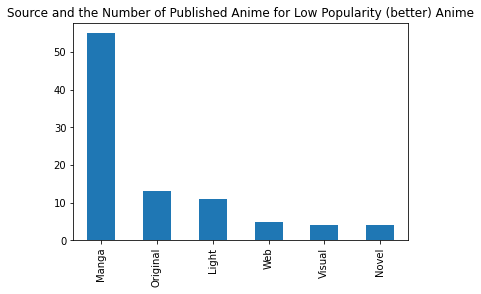

In [2151]:
plt.title('Source and the Number of Published Anime for Low Popularity (better) Anime')
source_appearances = df_lowpop['Source Type'].value_counts()
source_appearances[source_appearances>0].plot(kind = 'bar')

In [2152]:
df_highpop = df[df['Popularity']>5000]
df_highpop

,Title,MAL Id,Type,Number of Episodes,Episode Duration,Studios,Source Type,Genres,Themes,Rating,...,TV,Movie,OVA,ONA,Special,Shounen,Shoujo,Seinen,Josei,Kids
0,Bem,39221,TV,12,24 min. per ep.,"Production I.G,LandQ studios",Original,"Action,Supernatural",N\A,PG-13 - Teens 13 or older,...,1,0,0,0,0,0,0,0,0,0
1,Monster Strike: Zoku Saishuu-banashi - Pandora...,34661,ONA,1,8 min.,add some,Game,"Action,Fantasy",N\A,PG-13 - Teens 13 or older,...,0,0,0,1,0,0,0,0,0,0
3,Wellber no Monogatari: Sisters of Wellber,2032,TV,13,24 min. per ep.,Trans Arts,Original,"Action,Adventure,Comedy,Drama,Fantasy",N\A,PG-13 - Teens 13 or older,...,1,0,0,0,0,0,0,0,0,0
5,Gu-Gu Ganmo,3020,TV,50,25 min. per ep.,Toei Animation,Manga,"Comedy,Slice of Life",N\A,G - All Ages,...,1,0,0,0,0,1,0,0,0,0
6,Magnerobo Ga-Keen,3932,TV,39,24 min. per ep.,Toei Animation,Original,"Action,Sci-Fi",N\A,PG-13 - Teens 13 or older,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6202,Duel Masters Movie 2: Lunatic God Saga,6062,Movie,1,1 hr. 11 min.,add some,Original,"Action,Adventure,Comedy",N\A,G - All Ages,...,0,1,0,0,0,0,0,0,0,1
6204,Kuroi Ame ni Utarete,19135,Movie,1,1 hr. 34 min.,Tsuchida Productions,Manga,"Drama,Slice of Life",N\A,R+ - Mild Nudity,...,0,1,0,0,0,0,0,1,0,0
6205,Marginal Prince: Gekkeiju no Ouji-tachi - Toky...,18729,Special,1,24 min.,Tokyo Kids,Visual,"Boys Love,Romance",N\A,PG-13 - Teens 13 or older,...,0,0,0,0,1,0,0,0,0,0
6209,Nameko-ke no Ichizoku,20539,OVA,13,5 min. per ep.,add some,Game,"Comedy,Slice of Life",N\A,G - All Ages,...,0,0,1,0,0,0,0,0,0,0


We can conclude that Light for example appears many times in our top 100, and way less on 5000+. Hence, we expect that anime with Light source will recieve lower rank (which means better anime)

<AxesSubplot:title={'center':'Source and the Number of Published Anime for Low Popularity Anime'}>

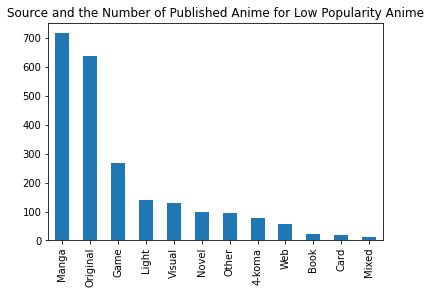

In [2153]:
plt.title('Source and the Number of Published Anime for Low Popularity Anime')
source_appearances = df_highpop['Source Type'].value_counts()
source_appearances[source_appearances>10].plot(kind = 'bar')

## Models ##

First of all we will split the data into a training set and a final test set.

In [2155]:
from sklearn.model_selection import train_test_split

x = df.drop(['Title', 'Episode Duration', 'Genres', 'Themes', 'Popularity', 'Studios', 'Source Type', 'Type', 'Rating', 'Demographic', 'MAL Id'], axis=1)
y = df[['Popularity']]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3)

### Dummies ###
To be able to truly understand and asses our models’ performance, we would need to establish a baseline for the data that we have. For that we would use a Dummy Model that doesn't try and find patterns in the given data. <br>
Lets run a dummy model to get our baseline:

In [2156]:
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import cross_val_score

In [2157]:
dummy_regr = DummyRegressor(strategy="mean")
score = abs(np.median(cross_val_score(dummy_regr, x_train, y_train, cv=30)))

print('Dummy\'s Score: {}'.format(score))

Dummy's Score: 0.0017159826048352977


### K Nearest Neighbor ###
K nearest neighbor is a relatively simple algorithm that is built around the concept that similar, or close, data would give similar results. In other words, similar things are near to each other.
The algorithm would search for the K nearest points (in the train sample) on the x axises and predicts that the y value would be a combination of those k point's y value.

In [2158]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_val_score

Lets find the most suitable K (nearest neighbors).

In [2159]:
k_range = range(1, 31)

scores = []
for k in k_range:
    knn = KNeighborsRegressor(n_neighbors=k)
    score = np.median(cross_val_score(knn, x_train, y_train, cv=30))
    scores.append(score)

index = scores.index(np.max(scores[1:])) + 1
print('Score: {}, Best Performing K: {}'.format(np.max(scores[1:]), index))

Score: 0.49352452627277843, Best Performing K: 6


Text(0.5, 1.0, 'Model Accuracy by K Nearest Neighbors')

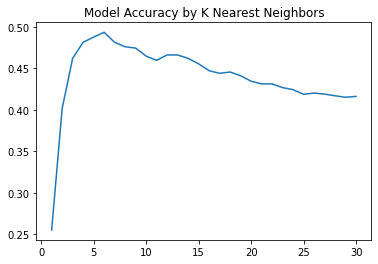

In [2160]:
plt.plot(k_range, scores)
plt.title('Model Accuracy by K Nearest Neighbors')

### Linear Regression ###
Linear regression is a linear model, meaning it assumes that y can be calculated from a linear combination of the input variables, x, and tries to calculate that very combination.

In [2161]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

In [2162]:
regressor = LinearRegression()
score = np.median(cross_val_score(regressor, x_train, y_train, cv=30))

print('Score: {}'.format(score))

Score: 0.9596779622920768


### Decision Tree Regressor ###
Decision Tree is a decision-making tool that uses a flowchart-like tree structure or is a model of decisions and all of their possible results, including outcomes, input costs, and utility. <br>
The decision hierarchy would be determined by each factor's gini impurity score (lowest preferred, and would be constructed of boolean conditions. In case we find a score of 0 we would know this factor is a leaf [the end of the tree and the deciding factor]). Once the gini impurity reaches a certain threshold of irrelevance we would conclude the decision path with a final boolean decision determined by the most common result.

Import 'DecisionTreeRegressor'.

In [2163]:
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor

Lets find the most suitable Depth.

In [2164]:
depth_range = range(1,31)

scores = []
for depth in depth_range:
    regressor = DecisionTreeRegressor(max_depth=depth)
    score = np.median(cross_val_score(regressor, x_train, y_train, cv=30))
    scores.append(score)

index = scores.index(np.max(scores[1:])) + 1
print('Score: {}, Best Performing Max Depth: {}'.format(np.max(scores), index))

Score: 0.9999708880972658, Best Performing Max Depth: 8


Text(0.5, 1.0, 'Model Accuracy by Max Depth')

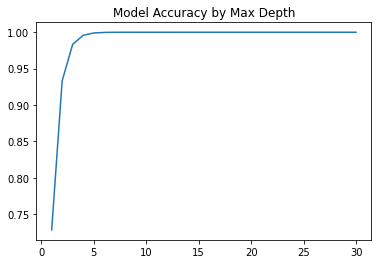

In [2165]:
plt.plot(depth_range, scores)
plt.title('Model Accuracy by Max Depth')

### Random Forest Regressor ###
A random forest is a meta estimator that fits a number of classifying decision trees on various random sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting.

Import 'RandomForestRegressor'.

In [2166]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor

In [2167]:
regressor = RandomForestRegressor()
score = np.median(cross_val_score(regressor, x_train, y_train, cv=30))

print('Score: {}'.format(score))

Score: 0.9999731924492272


### RME ###

In [2168]:
from sklearn.metrics import r2_score

def R2Score(model, model_name):
    model.fit(x_train, y_train)
    y_pred = model.predict(x_train)
    print( model_name + ': {}'.format(r2_score(y_train, y_pred)) )


R2Score( RandomForestRegressor(), 'RandomForestRegressor')
R2Score( KNeighborsRegressor(n_neighbors=11), 'KNeighborsRegressor')
R2Score( DecisionTreeRegressor(max_depth=5), 'DecisionTreeRegressor')
R2Score( LinearRegression(), 'LinearRegression')
R2Score( DummyRegressor(strategy="mean"), 'DummyRegressor')

RandomForestRegressor: 0.9999963236325891
KNeighborsRegressor: 0.5593711812461128
DecisionTreeRegressor: 0.9989577023987093
LinearRegression: 0.9621521823350319
DummyRegressor: 0.0


In [2169]:
from sklearn.metrics import mean_absolute_error

def MSEScore(model, model_name):
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    print( model_name + ': {}'.format(mean_absolute_error(y_test, y_pred)) )

MSEScore( RandomForestRegressor(), 'RandomForestRegressor')
MSEScore( KNeighborsRegressor(n_neighbors=11), 'KNeighborsRegressor')
MSEScore( DecisionTreeRegressor(max_depth=5), 'DecisionTreeRegressor')
MSEScore( LinearRegression(), 'LinearRegression')
MSEScore( DummyRegressor(strategy="mean"), 'DummyRegressor')

RandomForestRegressor: 10.581878576537907
KNeighborsRegressor: 1538.4481076863049
DecisionTreeRegressor: 73.70040498329539
LinearRegression: 399.4063799289163
DummyRegressor: 2253.5662219966703


In [2170]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3)

column_df = pd.DataFrame(columns=('column', 'mse', 'r2'))

for column in x_train.columns.values:
    x_train_t = x_train.drop(column, axis=1)
    x_test_t = x_test.drop(column, axis=1)

    model = RandomForestRegressor()
    model.fit(x_train_t, y_train)
    
    y_pred = model.predict(x_test_t)
    mse = np.sqrt(mean_absolute_error(y_test, y_pred))

    y_pred = model.predict(x_train_t)
    r2 = r2_score(y_train, y_pred)

    column_df = column_df.append({'column' : column, 'mse' : mse, 'r2' : r2}, ignore_index=True)

column_df.sort_values('mse')
column_df

In [ ]:
column_df.sort_values('mse')
column_df

,column,mse,r2
0,Number of Episodes,1216.842236,0.944227
1,Score,1422.906856,0.926307
2,Year,1300.219797,0.937527
3,Duration,1211.189049,0.944342
4,Action,1211.272691,0.94478
...,...,...,...
58,Shounen,1206.364557,0.944457
59,Shoujo,1211.163815,0.944342
60,Seinen,1208.42219,0.944154
61,Josei,1209.145354,0.944268


In [ ]:
lm3 = RandomForestRegressor()
from sklearn.metrics import mean_absolute_error
# Fitting the model
lm3.fit(x_train, y_train)
train_predict = lm3.predict(x_train)
k = mean_absolute_error(train_predict, y_train)
print('Training Mean Absolute Error', k )

test_predict = lm3.predict(x_test)
k = mean_absolute_error(test_predict, y_test)
print('Test Mean Absolute Error    ', k )

Training Mean Absolute Error 345.7473109694394
Test Mean Absolute Error     943.8595401322002
